In [343]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize, NonlinearConstraint
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sympy import det, Eq, eye, Indexed, Matrix, solve, Symbol

In [344]:
sns.set_theme(palette='tab10')

***
Цель __метода главных компонент (МГК)__ заключается в уменьшении размерности входных данных с минимальными потерями в информативности за счет подбора новой системы координат. Иными словами мы постараемся ввести новые предикторы для данных так, чтобы по новым предикторам информативность была максимальной. При этом мы не отбрасываем часть данных, а делаем некоторую композицию из признаков, которых в итоге становится меньше. Мы подбираем новую систему координат так, чтобы в ней данные больше всего отличались по первой оси, далее, из оставшихся, больше всего отличались по второй, и так далее.

***
## __Идея на примере__

Пусть в компании есть пять менеджеров по продаже автомобилей. Руководителю необходимо распределить премию между этими сотрудниками в зависимости от количества проданных автомобилей. Под рассмотрение попадают два предиктора: количество автомобилей премиум сегмента $X_1$ и количество автомобилей эконом сегмента $X_2$:

In [345]:
data = np.array([[9, 19], [6, 22], [11, 27], [12, 25], [7, 22]])
df = pd.DataFrame(data, columns=['Premium (X1)', 'Economy (X2)'])
df.index += 1
df.index.name = 'ID'
df

,Premium (X1),Economy (X2)
ID,,
1,9,19
2,6,22
3,11,27
4,12,25
5,7,22


Для решения задачи о распределении премии было бы удобно, чтобы каждого сотрудника характеризовало одно число $z_i$, причем сотрудники должны быть максимально различимы:

$$z_i = \varphi_1\,x_{i1} + \varphi_2\,x_{i2},\;i = \{1, \dots ,5\},$$

где $x_{i1},\,x_{i2}$ - соответственно количество автомобилей премиум и эконом сегментов, проданных $i$-ым сотрудником, т.е. каждый объект-сотрудник отождествляется с вектором, имеющим две координаты, или точкой на плоскости.

После центрирования данных, подбора коэффициентов $\varphi_1$ и $\varphi_2$ и схлопывания исходного $\R^2$-пространства признаков в $\R^1$ каждому объекту будет соответствовать единственная координата $z_i$. Тогда координаты всех объектов $x_1, \dots ,x_n$ можно записать в виде вектора-столбца:

$$Z = \begin{pmatrix} z_1 \\ \vdots \\ z_n \end{pmatrix}$$

Если объект характеризуется единственным признаком, то его можно представить в виде точки на прямой. При этом, так как объекты центрированы, то разумно требовать, чтобы эта прямая проходила через начало координат, - тогда новые объекты останутся центрированными и относительно старой системы координат. Кроме того, мы хотим провести новую прямую так, чтобы новые координаты как можно сильнее различались между собой. В качестве меры различия при этом будем использовать выборочную дисперсию:

$$\Large s^2_Z = \frac{1}{n}\sum_{i=1}^n\bigl(z_i - \overline{Z}\bigr)^2 \rightarrow \max_{\varphi}$$

Прямая, проходящая через начало координат, такая, что координаты проекций центрированных исходных объектов на нее обладают наибольшей выборочной дисперсией, называется __первой главной компонентой__ и обозначается PC1 (first principal component).

Направляющие векторы $\varphi$ и $-\varphi$ первой ГК, имеющие длину $1$ и отличающиеся только направлением, называются, по отдельности, __вектором весов__ первой ГК.

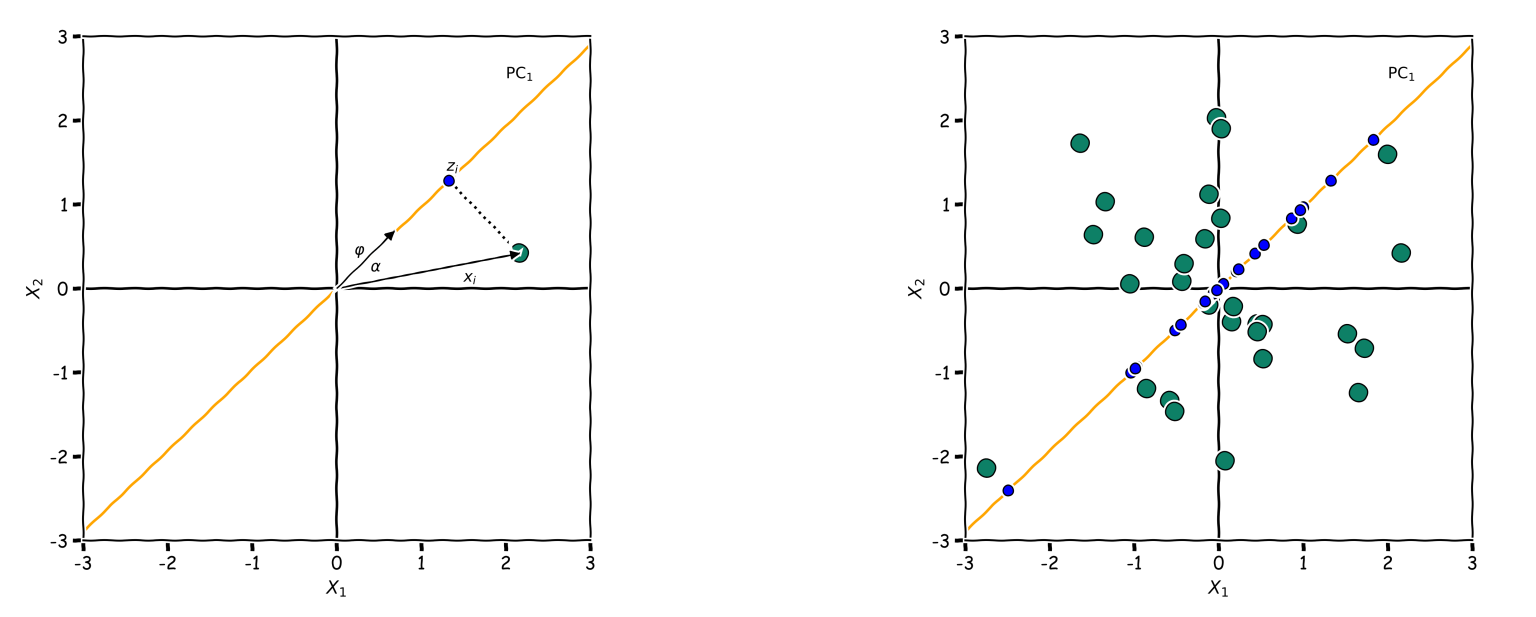

Новая координата $z_i$ на прямой PC1 с базисным (в данном случае совпадающим с вектором весов) вектором $\varphi$:

$$z_i = \langle x_i,\varphi \rangle = |x_i| \cdot |\varphi|\,\cos{\alpha} = |x_i|\,\cos{\alpha} = \varphi_1\,x_{i1} + \varphi_2\,x_{i2}.$$

Задача сводится к поиску таких весов $\varphi_1$ и $\varphi_2$, то есть к поиску такого способа проведения прямой, чтобы координаты проекций точек на эту прямую различались наиболее сильно, то есть обладали наибольшей выборочной дисперсией.

Вторая и последующие $k$ главных компонент ($2 \leqslant k \leqslant p$, $p$ - размерность пространства признаков), строятся так, чтобы они также проходили через начало координат (ради сохранения центрированности объектов) __ортогонально всем ранее построенным ГК__. Требование ортогональности главных компонент обеспечивает отсутствие корреляции между новыми признаками объектов. При этом каждая последующая ГК строится так, чтобы выборочная дисперсия координат проекций исходных данных на нее была максимальной.

***
## __Нахождение первой главной компоненты__

__Матрица исходных данных__ $n \times p$:

$$F = \begin{pmatrix}x_{11} & ... & x_{1p} \\
\vdots & \ddots & \vdots \\
x_{n1} & ... & x_{np}\end{pmatrix},$$

где в $i$-ой строке находятся $1, \dots ,p$-ый признаки $i$-ого объекта. 

__Направляющий вектор__ первой ГК:
$$\varphi_1 = \begin{pmatrix}\varphi_{11} \\ \vdots \\ \varphi_{p1}\end{pmatrix}$$
$$|\varphi_1| = \sqrt{\varphi_{11}^2 +...+ \varphi_{p1}^2} = 1, \quad \varphi_{11}^2 +...+ \varphi_{p1}^2 = 1$$

__Вектор счетов__ первой ГК:

$$Z_1 = \begin{pmatrix} z_{11} \\ \vdots \\ z_{n1} \end{pmatrix}$$

Тогда $Z_1 = F\varphi_1$:

$$\begin{pmatrix}x_{11} & \dots & x_{1p} \\
\vdots & \ddots & \vdots \\
x_{n1} & \dots & x_{np}\end{pmatrix}\begin{pmatrix}\varphi_{11} \\ \vdots \\ \varphi_{p1}\end{pmatrix} = \begin{pmatrix}x_{11}\varphi_{11}+\dots+x_{1p}\varphi_{p1} \\ \vdots \\ x_{n1}\varphi_{11}+\dots+x_{np}\varphi_{p1} \end{pmatrix} = \begin{pmatrix} z_{11} \\ \vdots \\ z_{n1} \end{pmatrix}$$

$$s^2_{Z_1} = \overline{Z_1^2} - \overline{Z_1}^2 = \frac{1}{n}\sum_{i=1}^n z_{i1}^2 - \overbrace{\Biggl(\frac{1}{n}\sum_{i=1}^n z_{i1}\Biggr)^2}^{0}$$

$$\frac{1}{n}\sum_{i=1}^n z_{i1} = \frac{1}{n}\sum_{i=1}^n (\varphi_{11}x_{i1}+ \dots +\varphi_{p1}x_{ip}) = \varphi_{11}\frac{1}{n}\sum_{i=1}^n x_{i1} + \dots + \varphi_{p1}\frac{1}{n}\sum_{i=1}^n x_{ip} = 0,$$

поскольку все признаки центрированы!

$$\Large s^2_{Z_1} = \frac{1}{n}\sum_{i=1}^n z_{i1}^2 \rightarrow \max_{\varphi_1}$$

при условии $|\varphi_1| = 1$. Так как в выражении мы вольны менять только координаты $\varphi_1$, то задача сводится к нахождению вектора весов $\varphi_1$, при котором $s^2_{Z_1}$ будет максимальной. Так как задача оптимизации не зависит от $n$, __максимизировать нужно квадрат длины вектора $Z_1$: мы ищем такой вектор весов, что квадрат длины $|Z_1|^2$ вектора счетов $Z_1$ максимален__.

Вернемся к примеру с продавцами автомобилей. Выполним центрирование данных:

In [346]:
data_cen = scale(data, with_std=False)  # data - data.mean(axis=0)
data_cen

array([[ 0., -4.],
       [-3., -1.],
       [ 2.,  4.],
       [ 3.,  2.],
       [-2., -1.]])

Вектор счетов первой ГК:

$$Z_1 = \begin{pmatrix}0 & -4 \\ -3 & -1 \\
2 & 4 \\ 3 & 2 \\ -2 & -1\end{pmatrix} \begin{pmatrix}\varphi_{11} \\ \varphi_{21}\end{pmatrix} = \begin{pmatrix}-4\varphi_{21} \\ -3\varphi_{11}-\varphi_{21} \\ 2\varphi_{11}+4\varphi_{21} \\ 3\varphi_{11}+2\varphi_{21} \\ -2\varphi_{11}-\varphi_{21}\end{pmatrix}$$

In [347]:
F = Matrix(data_cen)
phim = Matrix([Indexed('\\varphi', i) for i in (1,2)])
Z = F * phim
Z

Matrix([
[                 -4.0*\varphi[2]],
[-3.0*\varphi[1] - 1.0*\varphi[2]],
[ 2.0*\varphi[1] + 4.0*\varphi[2]],
[ 3.0*\varphi[1] + 2.0*\varphi[2]],
[-2.0*\varphi[1] - 1.0*\varphi[2]]])

Квадрат длины $|Z_1|^2$ вектора счетов первой ГК:

In [348]:
(Z.T @ Z).expand()[0]

26.0*\varphi[1]**2 + 38.0*\varphi[1]*\varphi[2] + 38.0*\varphi[2]**2

Найдем оптимизацией максимум функции двух переменных выше при ограничении $\varphi_{11}^2 + \varphi_{21}^2 = 1$:

In [349]:
f = lambda x: -26*x[0]**2 - 38*x[0]*x[1] - 38*x[1]**2
nlc = NonlinearConstraint(lambda x: x[0]**2 + x[1]**2, 0, 1)
res = minimize(f, (1/np.sqrt(2),)*2, constraints=nlc)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -51.924860170015236
       x: [ 5.911e-01  8.066e-01]
     nit: 5
     jac: [-6.139e+01 -8.376e+01]
    nfev: 17
    njev: 4

Координаты направляющего вектора $\varphi_1$ первой ГК:

In [350]:
phi = res.x
phi

array([0.59112984, 0.80657643])

Новые координаты, или счёты, - координаты проекций исходных объектов на прямую первой ГК. Иначе говоря, это координаты объектов в базисе первой ГК.

In [351]:
scores_pc1 = data_cen @ phi
scores_pc1

array([-3.22630572, -2.57996595,  4.4085654 ,  3.38654238, -1.98883611])

Координаты проекций в стандартном базисе (массив абсцисс, массив ординат):

In [352]:
data_pc1 = np.multiply(scores_pc1, phi.reshape(-1,1))
data_pc1

array([[-1.90716558, -1.52509486,  2.60603456,  2.00188626, -1.17566037],
       [-2.60226215, -2.08093973,  3.55584494,  2.73150526, -1.60414833]])

Уравнение прямой первой ГК:
$$X_2 = \frac{\varphi_{21}}{\varphi_{11}}X_1$$

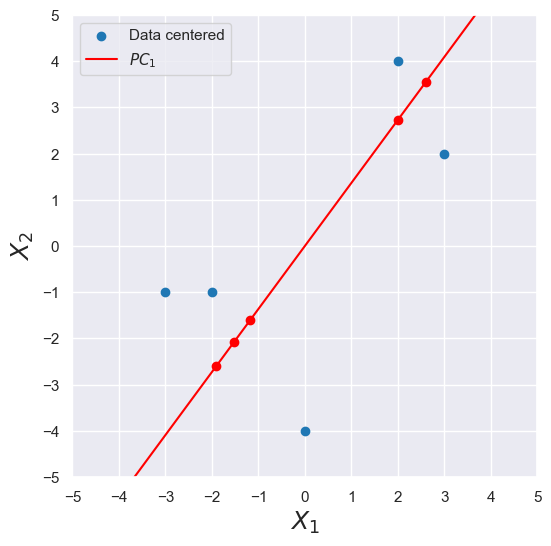

In [353]:
x = range(-5, 6)
bounds = x[0], x[-1]
slope_pc1 = np.divide(*np.flip(phi))

plt.figure(figsize=(6,6))
plt.scatter(*data_cen.T, label='Data centered')
plt.scatter(*data_pc1, c='r')
plt.plot(x, slope_pc1 * x, c='r', label='$PC_1$')
plt.xlabel('$X_1$', fontsize=18)
plt.ylabel('$X_2$', fontsize=18)
plt.xlim(*bounds)
plt.ylim(*bounds)
plt.xticks(x)
plt.yticks(x)
plt.legend()
plt.show()

Теперь каждого менеджера характеризует одно число, а значит, если упорядочить результаты по убыванию, наибольшую премию должен получить сотрудник с номером $i=3$, затем сотрудник с номером $i=4$ и так далее. Заметим, что отрицательные результаты не значат, что сотрудников нужно оштрафовать, просто чем меньше значение, тем меньшей премии достоен сотрудник. Победитель:

In [354]:
scores_pc1[2]

4.408565400865281

***
## __Общее решение: руками__

Пусть $F$ - центрированная матрица исходных данных $n \times p$, содержащая информацию об $n$ объектах, обладающих $p$ признаками.

Тогда $\Theta$, выборочная ковариационная матрица:

$$\Large \Theta = \frac{1}{n}\left(F^T \cdot F\right)$$

При сокращении размерности, чтобы потерять как можно меньше информации, разумно в качестве вектора весов первой ГК брать собственный вектор, отвечающий наибольшему из собственных чисел матрицы $\Theta$, в качестве вектора весов второй ГК брать собственный вектор, отвечающий следующему по величине собственному числу матрицы $\Theta$ и так далее.

__Refresh__. Пусть дано линейное преобразование $A : \R^n \rightarrow \R^n$.
<br>__Собственным вектором__ преобразования $A$ называется ненулевой вектор $\vec{v} \in \R^n$ такой, что $A\vec{v} = \lambda \vec{v}$ для какого-нибудь числа $\lambda \in \R$.
Иначе говоря, собственный вектор преобразования это такой вектор, действуя на который преобразование изменяет только его длину, но не направление.
<br>__Собственными числами__ преобразования $A$ называются корни уравнения $\det(A - \lambda\text{E}) = 0$.

[__numpy.linalg.eig__](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html#numpy-linalg-eig) | [__numpy.cov__](https://numpy.org/doc/stable/reference/generated/numpy.cov.html#numpy-cov)

In [355]:
covar = np.cov(data_cen, rowvar=False, ddof=0)
np.allclose(covar, (data_cen.T @ data_cen) / data_cen.shape[0])

True

### __sympy__

Собственные числа и соответствующие собственные вектора готовым методом матрицы:

In [356]:
covarm = Matrix(covar)
covarm.left_eigenvects()

[(2.41502823096575, 1, [Matrix([[-0.806576520838878, 0.591129694763722]])]),
 (10.3849717690343, 1, [Matrix([[-0.591129694763722, -0.806576520838878]])])]

Собственные числа из $|\Theta - \lambda \text{E}| = 0$:

In [357]:
lamb = Symbol('lambda')
lambs = solve(det(covarm - lamb * eye(2)))
lambs

[2.41502823096575, 10.3849717690343]

Собственные вектора, соответствующие найденным собственным числам, из 
$\Theta \varphi_i = \lambda_i \varphi_i$:

In [358]:
records = []
EigRec = namedtuple('EigRec', ['eigval', 'eigvecs'])

for lamb in sorted(lambs, reverse=True):
    M = covarm * phim - lamb * phim
    solutions = solve([M[0], Eq(phim[0]**2 + phim[1]**2, 1)])
    eigvecs = tuple(np.array([*sol.values()], dtype=float)
                    for sol in solutions)
    records.append(EigRec(eigval=float(lamb), eigvecs=eigvecs))
        
records

[EigRec(eigval=10.384971769034255, eigvecs=(array([-0.59112969, -0.80657652]), array([0.59112969, 0.80657652]))),
 EigRec(eigval=2.415028230965745, eigvecs=(array([-0.80657652,  0.59112969]), array([ 0.80657652, -0.59112969])))]

### __numpy__

In [359]:
val, vec = np.linalg.eig(covar)

Собственные числа ковариационной матрицы центрированных признаков:

In [360]:
val

array([ 2.41502823, 10.38497177])

Собственные вектора ковариационной матрицы центрированных признаков:

In [361]:
vec

array([[-0.80657652, -0.59112969],
       [ 0.59112969, -0.80657652]])

> The eigenvalues are not necessarily ordered. 

Поскольку порядок собственных векторов (столбцов __`vec`__) соответствует порядку собственных чисел в __`val`__, для идентификации первой ГК необходимо выполнить сортировку собственных векторов по убыванию собственных чисел:

In [362]:
ix = np.flip(np.argsort(val))

Теперь первый столбец соответствует PC1:

In [363]:
vec = vec[:, ix]
vec

array([[-0.59112969, -0.80657652],
       [-0.80657652,  0.59112969]])

Направляющий вектор ГК указывает направление роста нового обобщенного признака (счета). Чтобы больший счет соответствовал более высокому результату в задаче о продавцах автомобилей, согласуем решение с оптимизационным выше - из двух противоположных направляющих векторов первой ГК выберем тот, у которого обе координаты положительные. Другими словами, изменим знак матрицы собственных векторов на противоположный:

In [364]:
vec *= -1
vec

array([[ 0.59112969,  0.80657652],
       [ 0.80657652, -0.59112969]])

Столбцы счетов PC1 и PC2 соответственно:

In [365]:
scores = data_cen @ vec
scores

array([[-3.22630608,  2.36451878],
       [-2.57996561, -1.82859987],
       [ 4.40856547, -0.75136574],
       [ 3.38654213,  1.23747017],
       [-1.98883591, -1.02202335]])

Возврат к центрированным данным:

In [366]:
np.allclose(scores @ vec.T, data_cen)

True

__Важное замечание__ насчет матрицы перехода $\Phi$. В записях преобразования $Z = F \Phi$ и возврата к данным $F = Z \Phi^T$ предполагается, что собственные вектора - __столбцы__ $\Phi$ ("numpy-случай"): __`numpy.linalg.eig`__, в отличие от атрибута __`components_`__ класса __`sklearn.decomposition.PCA`__, возвращает собственные вектора __столбцами__, а не построчно.

Добавим на график PC2:

In [367]:
data_pc2 = np.multiply(scores[:,1], vec[:,1].reshape(-1,1))
data_pc2

array([[ 1.90716533, -1.47490572, -0.60603396,  0.99811439, -0.82434004],
       [-1.39773726,  1.08093968,  0.4441546 , -0.73150537,  0.60414835]])

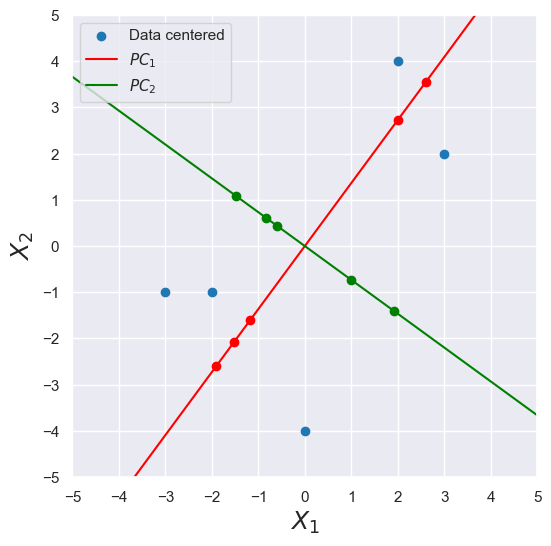

In [368]:
x = range(-5, 6)
slope_pc1 = np.divide(*np.flip(phi))
slope_pc2 = np.divide(*np.flip(vec[:,1]))

plt.figure(figsize=(6,6))
plt.scatter(*data_cen.T, label='Data centered')
plt.scatter(*data_pc1, c='r')
plt.scatter(*data_pc2, c='g')
plt.plot(x, slope_pc1 * x, c='r', label='$PC_1$')
plt.plot(x, slope_pc2 * x, c='g', label='$PC_2$')
plt.xlabel('$X_1$', fontsize=18)
plt.ylabel('$X_2$', fontsize=18)
plt.xlim(*bounds)
plt.ylim(*bounds)
plt.xticks(x)
plt.yticks(x)
plt.legend(loc='upper left')
plt.show()

$i$-ое собственное число равно дисперсии счетов $i$-ой ГК:

In [369]:
scores_var = scores.var(axis=0)
scores_var

array([10.38497177,  2.41502823])

In [370]:
np.allclose(scores_var, np.flip(val))

True

Невооруженным глазом видно, что разброс проекций на красную прямую больше разброса проекций на зеленую.

***
## __Общее решение: sklearn.decomposition.PCA__

[__sklearn.decomposition.PCA__](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn-decomposition-pca)

In [371]:
pca = PCA()
data_trans = pca.fit_transform(data)
data_trans # счеты

array([[-3.22630608,  2.36451878],
       [-2.57996561, -1.82859987],
       [ 4.40856547, -0.75136574],
       [ 3.38654213,  1.23747017],
       [-1.98883591, -1.02202335]])

In [372]:
pca.components_

array([[ 0.59112969,  0.80657652],
       [ 0.80657652, -0.59112969]])

> Principal axes in feature space, representing the directions of maximum variance in the data. Equivalently, the right singular vectors of the centered input data, parallel to its eigenvectors. The components are sorted by decreasing __`explained_variance_`__.

__Важное замечание__ насчет матрицы перехода $\Phi$. В записях преобразования $Z = F \Phi$ и возврата к данным $F = Z \Phi^T$ предполагается, что собственные вектора - __столбцы__ $\Phi$ ("numpy-случай"). Однако __`components_`__, в отличие от __`numpy.linalg.eig`__, возвращает собственные вектора __построчно__, а не столбцами.

In [373]:
np.allclose(data_cen @ pca.components_.T, data_trans)

True

In [374]:
expl = pca.explained_variance_ # важно: ddof=1, а не 0
expl

array([12.98121471,  3.01878529])

In [375]:
np.linalg.eig(np.cov(data_cen, rowvar=False, ddof=1))[0]

array([ 3.01878529, 12.98121471])

In [376]:
pca.explained_variance_ratio_

array([0.81132592, 0.18867408])

In [377]:
expl / expl.sum()

array([0.81132592, 0.18867408])

In [378]:
np.cumsum(pca.explained_variance_ratio_)

array([0.81132592, 1.        ])

In [379]:
data_inv = pca.inverse_transform(data_trans)  # исходные нецентрированные данные
data_inv

array([[ 9., 19.],
       [ 6., 22.],
       [11., 27.],
       [12., 25.],
       [ 7., 22.]])

In [380]:
m = data.mean(axis=0)

In [381]:
np.allclose(data_trans @ pca.components_ + m, data_inv)

True

In [382]:
np.allclose(data_inv, data)

True

In [383]:
pca.singular_values_

array([7.20589057, 3.47493038])

[__scipy.linalg.svd__](https://scipy.github.io/devdocs/reference/generated/scipy.linalg.svd.html#scipy-linalg-svd) | [__linalg_decomp.ipynb__](https://github.com/EvgenyMeredelin/math-for-data-science/blob/main/linalg_decomp.ipynb).

In [384]:
U, s, Vh = np.linalg.svd(data_cen, full_matrices=False)

In [385]:
U

array([[ 0.44773176, -0.68045069],
       [ 0.35803564,  0.52622633],
       [-0.61180023,  0.21622469],
       [-0.46996858, -0.35611366],
       [ 0.2760014 ,  0.29411333]])

In [386]:
s

array([7.20589057, 3.47493038])

In [387]:
Vh

array([[-0.59112969, -0.80657652],
       [-0.80657652,  0.59112969]])

In [388]:
U * s  # поэлементно

array([[ 3.22630608, -2.36451878],
       [ 2.57996561,  1.82859987],
       [-4.40856547,  0.75136574],
       [-3.38654213, -1.23747017],
       [ 1.98883591,  1.02202335]])

In [389]:
U * s @ Vh  # data_cen

array([[ 6.30809e-16, -4.00000e+00],
       [-3.00000e+00, -1.00000e+00],
       [ 2.00000e+00,  4.00000e+00],
       [ 3.00000e+00,  2.00000e+00],
       [-2.00000e+00, -1.00000e+00]])

***
## __Восстановление признаков по главным компонентам__

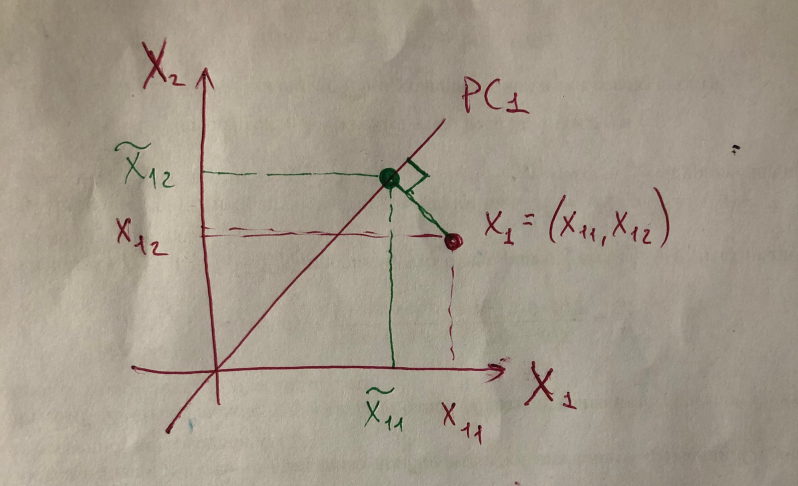

In [390]:
# восстановление по PC1
data_restored = data_trans[:,0].reshape(-1,1) * pca.components_[0] + m
data_restored

array([[ 7.09283467, 20.39773726],
       [ 7.47490572, 20.91906032],
       [11.60603396, 26.5558454 ],
       [11.00188561, 25.73150537],
       [ 7.82434004, 21.39585165]])

In [391]:
data  # для сравнения: исходные нецентрированные данные

array([[ 9, 19],
       [ 6, 22],
       [11, 27],
       [12, 25],
       [ 7, 22]])